<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Firstly let's install and upgrade the necessary packages

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.5 MB/s eta 0:00:00


Let's import all the necessary functions and packages

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from dl_utils import plot_history

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score


Check the versions of the packages

In [5]:
print(tf.__version__)
print(keras.__version__)

2.15.0
3.0.5


Check the runtime device

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

Load the training and test set and display its shape

In [7]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)


Show the first instance and corresponding label

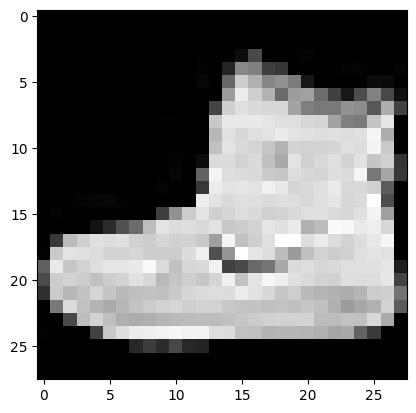

Label = 9


In [8]:
# Show an instance
plt.imshow(X_train[0], cmap="gray")
plt.show()

# Print label
print("Label =", y_train[0])


Preprocess the feature vectors

In [9]:
# Input data preprocessing
print(np.min(X_train), np.max(X_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 255
60000 train samples
10000 test samples


Preprocess the labels

In [10]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 9
First label is now =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Build the models


## Baseline model
Here we implement the MLP seen in the lab: we use a simple fully connected network here using 8 hidden neurons, followed by another layer of 8 hidden neurons, and finally our output layer. We use the ReLU activation function, except for the output, where we apply a softmax activation as we're doing a multiclass classification here.

This model represents the baseline that we want to improve.

In [11]:
def MLPModel(num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [12]:
model = MLPModel(num_classes)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

## Our model

Here we implement our version of the MLP by creating wrapper class for the HyperModel of the Keras Tuner class, in order to perform our custom search via Hyperband algorithm of the best hyperparameters of our model. The hyperparameters we tune are the number of neurons in the two hidden layers, the activation function, the learning rate, the batch size. We perform data augmentation in the fit function to allow the model to deal with different image transformations. We split the training data into a training and validation set to improve the generalization.

In [13]:
class MyMLPModel(kt.HyperModel):
  # build function to override
  def build(self, hp):
        model = self.build_MLP(hp)
        return model

  # Sets up the hyperparameters and calls the actual building model function
  def build_MLP(self, hp):
      # Tune the number of units for the Dense layers
      hp_units1 = hp.Int('unitsL1', min_value=32, max_value=512, step=32)
      hp_units2 = hp.Int('unitsL2', min_value=32, max_value=512, step=32)

      # Choose the activation function for the Dense layers
      hp_activation = hp.Choice("activation", ["relu", "tanh"])

      # Tune the learning rate for the optimizer
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      # call existing model-building code with the hyperparameter values.
      model = self.build_MLP_hp(
          hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
          hp_learning_rate=hp_learning_rate
      )
      return model

  # Builds the model given the parameters
  def build_MLP_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate):
      model = Sequential()
      model.add(Flatten(input_shape=(28, 28)))
      model.add(Dense(units=hp_units1, activation=hp_activation))
      model.add(Dense(units=hp_units2, activation=hp_activation))
      model.add(Dense(10, activation="softmax"))
      model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss="categorical_crossentropy", metrics=["accuracy"])
      return model

  # fit function to override
  def fit(self, hp, model, *args, **kwargs):
        # Initialize ImageDataGenerator for data augmentation specifying a bunch of different transformations
        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode='nearest',
            validation_split=0.2
        )
        # Retrieve the training data
        X_train = args[0]
        # Increase the dimensionality of the data for datagen
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
        # Fit the data generator on the training data
        datagen.fit(X_train)
        # Tune the batch size
        hp_batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128, 256])
        # Use the generator to augment the data during training
        return model.fit(
        datagen.flow(X_train, y_train, batch_size=hp_batch_size, shuffle=True, subset='training'), # Use augmentation on the training set
        validation_data=datagen.flow(X_train, y_train, subset='validation'),  # Use augmentation on the validation set
        )

The hyperband tuner object allows to perform the search of the hyperparameters using hyperband algorithm.

In [14]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner = kt.Hyperband(MyMLPModel(),
                     objective='val_accuracy',
                     max_epochs=10,
                     #overwrite = True,
                     max_consecutive_failed_trials=5,
                     project_name='my_mlp_tuning',
                     directory='my_mlp_tuning',
)
# Summarize the search space
tuner.search_space_summary()

Search space summary
Default search space size: 4
unitsL1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
unitsL2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3289 - loss: 1.7250 - val_accuracy: 0.7027 - val_loss: 0.9966
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7358 - loss: 0.9098 - val_accuracy: 0.7874 - val_loss: 0.6972
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - loss: 0.6539 - val_accuracy: 0.8036 - val_loss: 0.5689
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8068 - loss: 0.5571 - val_accuracy: 0.8089 - val_loss: 0.5446
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8189 - loss: 0.5229 - val_accuracy: 0.8211 - val_loss: 0.5182


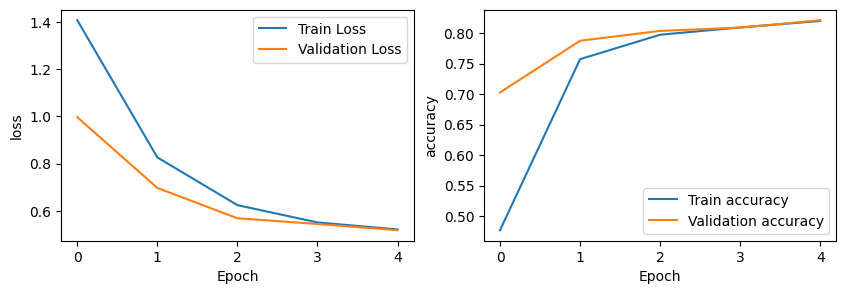

In [15]:
batch_size = 128
epochs = 5

# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
plot_history(history)

## Training the best model

Here we first perform the search of the best parameters using the hyperband tuner previously defined, then we train the best model with a train-validation split. We specify a high number of epochs because the early stopping function allows to stop the training by monitoring the validation loss, to prevent overfitting.

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7799 - loss: 0.6020 - val_accuracy: 0.8518 - val_loss: 0.4061
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8550 - loss: 0.3919 - val_accuracy: 0.8556 - val_loss: 0.3903
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8699 - loss: 0.3511 - val_accuracy: 0.8629 - val_loss: 0.3630
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8785 - loss: 0.3246 - val_accuracy: 0.8727 - val_loss: 0.3523
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8868 - loss: 0.3061 - val_accuracy: 0.8707 - val_loss: 0.3664
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8922 - loss: 0.2872 - val_accuracy: 0.8708 - val_loss: 0.3535
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8984 - loss: 0.2674 - val_accuracy: 0.8725 - val_loss: 0.3685
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8997 - loss: 0.2629 - 

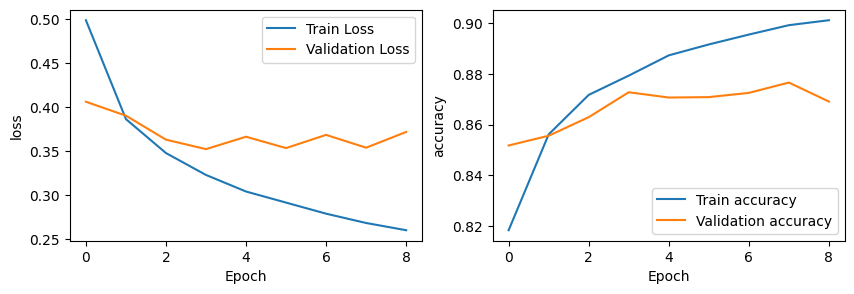

Best epoch: 8


In [23]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform the search
tuner.search(X_train, y_train, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

model.save('/content/best_model.keras')

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

# Evaluation

## Baseline evaluation

Print the scores of the trained baseline model.

In [24]:
base_score = model.evaluate(X_test, y_test, verbose=0)

print("Baseline model")
print("Test loss:", base_score[0])
print("Test accuracy:", base_score[1])

Baseline model
Test loss: 0.5401682257652283
Test accuracy: 0.8112000226974487


## Best model evaluation

Print the scores of the best model.
Print the increment in the test set's accuracy.

In [25]:
best_score = best_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score[0])
print("Test accuracy:", best_score[1])
print("Test accuracy improvement:", 100*(best_score[1]-base_score[1])/base_score[1], "%")

Best model
Best parameters: {'unitsL1': 352, 'unitsL2': 480, 'activation': 'tanh', 'learning_rate': 0.001, 'batch_size': 64, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Test loss: 0.4026128947734833
Test accuracy: 0.8596000075340271
Test accuracy improvement: 5.966467391807506 %


## Best and worst predictions

Here we plot the 5 best and 5 worst predictions and make some hypotheses on the reasons.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


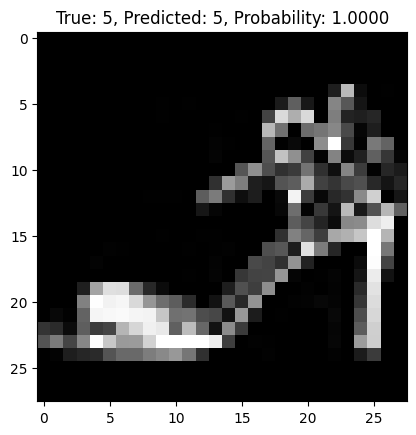

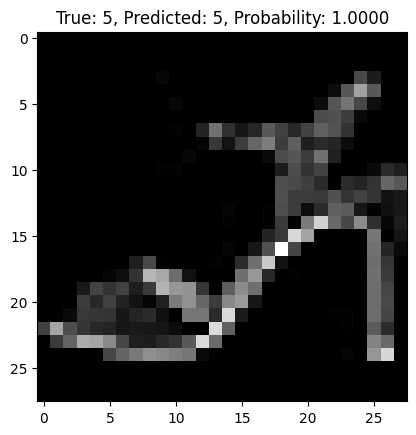

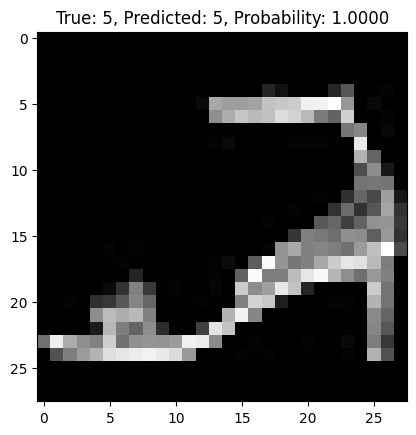

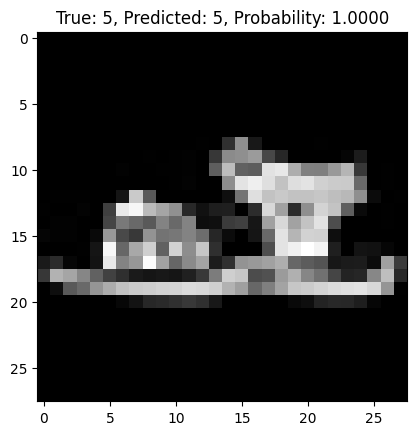

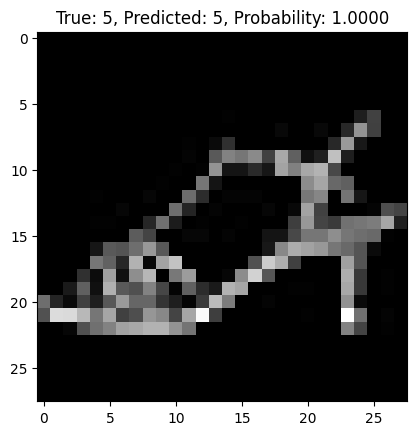

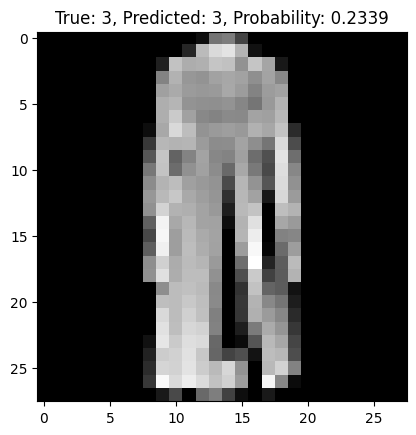

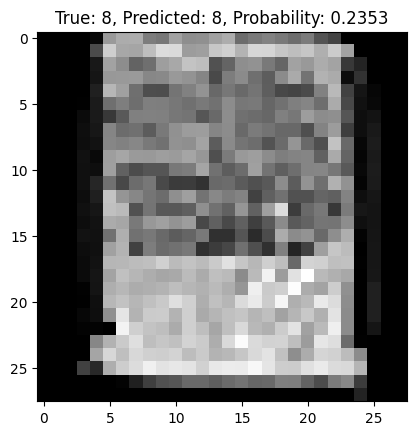

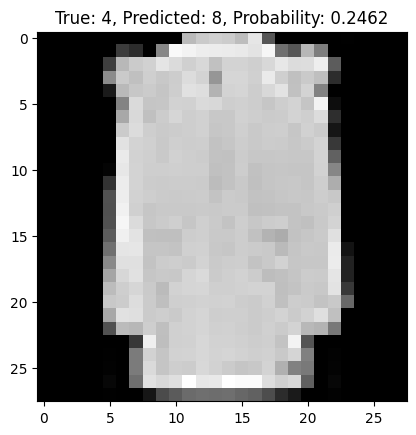

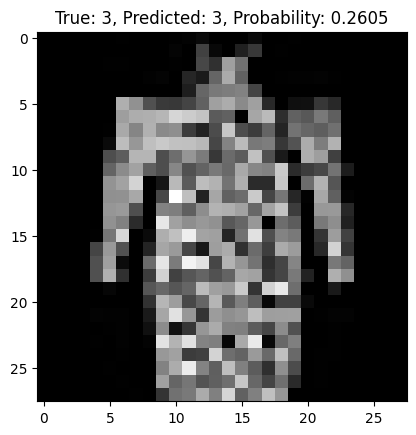

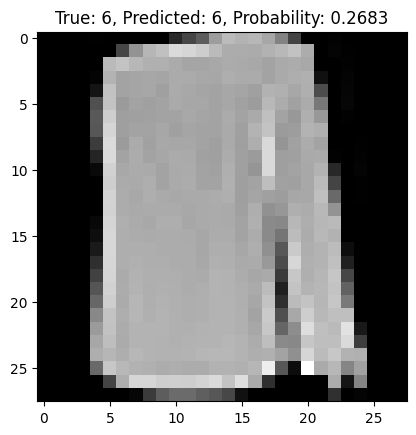

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      6000
           1       0.99      0.99      0.99      6000
           2       0.86      0.85      0.85      6000
           3       0.94      0.91      0.93      6000
           4       0.88      0.79      0.83      6000
           5       0.98      0.98      0.98      6000
           6       0.69      0.88      0.77      6000
           7       0.97      0.95      0.96      6000
           8       0.99      0.98      0.98      6000
           9       0.95      0.97      0.96      6000

    accuracy                           0.91     60000
   macro avg       0.92      0.91      0.91     60000
weighted avg       0.92      0.91      0.91     60000



In [36]:
y_pred_probs = best_model.predict(X_train)

y_max_probs = list(range(len(y_pred_probs)))

y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true_labels = np.argmax(y_train, axis=1)

for i, row in enumerate(y_pred_probs):
  y_max_probs[i] = np.max(row)

indices = np.argsort(y_max_probs)

most_convinced_indices = indices[-5:]
most_confused_indices = indices[:5]

for index in most_convinced_indices:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

for index in most_confused_indices:
    plt.imshow(X_train[index],cmap="gray")
    plt.title(f'True: {y_true_labels[index]}, Predicted: {y_pred_labels[index]}, Probability: {y_pred_probs[index, y_pred_labels[index]]:.4f}')
    plt.show()

print(classification_report(y_true_labels, y_pred_labels))


The model exhibits weaknesses in accurately predicting clothing items like coats or dresses, while demonstrating strengths in classifying bags trousers and shoes. There is an opportunity for improvement by focusing on enhancing the model's performance in the classification of clothing items.

In [47]:
# check dataset for unbalances. Then tune the weight of the classes depending on the number of samples to compensate the unbalance.

# Count the number of occurrences of 1 in each column
count = np.sum(y_train, axis=0)

# Print the count of ones for each class (column)
for class_label, sum in enumerate(count):
    print(f"Class {class_label}: samples {sum}")

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

# Initialize the class_weights dictionary
class_weights = {}

f1_scores = []

# Extract F1-score for each class and fill class_weights
for class_label, metrics in report.items():
    if class_label.isdigit():  # Check if the key is a class label
        f1_score = metrics['f1-score']
        f1_scores.append(f1_score)
        class_weights[int(class_label)] = 1/(f1_score**2)

print("Class weights based on F1 scores:", class_weights)

Class 0: samples 6000.0
Class 1: samples 6000.0
Class 2: samples 6000.0
Class 3: samples 6000.0
Class 4: samples 6000.0
Class 5: samples 6000.0
Class 6: samples 6000.0
Class 7: samples 6000.0
Class 8: samples 6000.0
Class 9: samples 6000.0
Class weights based on F1 scores: {0: 1.29383870337563, 1: 1.0171423024990882, 2: 1.35509340792384, 3: 1.1942513330810516, 4: 1.3558889360406738, 5: 1.0346234884189853, 6: 1.5100207391236677, 7: 1.0797083257332134, 8: 1.023446659285975, 9: 1.0547700447086015}


Now we are going to retrain the model with this clases

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9285 - loss: 0.2507 - val_accuracy: 0.8831 - val_loss: 0.3704
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9307 - loss: 0.2397 - val_accuracy: 0.8882 - val_loss: 0.3453
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9307 - loss: 0.2529 - val_accuracy: 0.8841 - val_loss: 0.3700
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9272 - loss: 0.2514 - val_accuracy: 0.8822 - val_loss: 0.3952
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9319 - loss: 0.2444 - val_accuracy: 0.8828 - val_loss: 0.3815


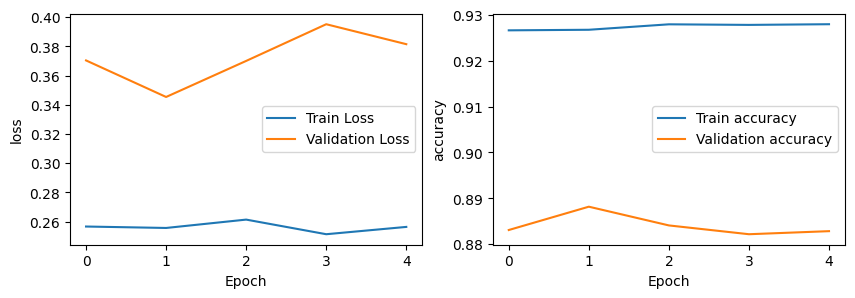

Best epoch: 2


In [48]:
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weights, callbacks=[stop_early])

plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

In [49]:
best_score1 = best_model.evaluate(X_test, y_test, verbose=0)

print("Best model")
print("Best parameters:", best_hps.values)
print("Test loss:", best_score1[0])
print("Test accuracy:", best_score1[1])
print("Test accuracy improvement:", 100*(best_score1[1]-best_score[1])/best_score[1], "%")

Best model
Best parameters: {'unitsL1': 352, 'unitsL2': 480, 'activation': 'tanh', 'learning_rate': 0.001, 'batch_size': 64, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Test loss: 0.40470197796821594
Test accuracy: 0.8791999816894531
Test accuracy improvement: 2.2801272665938366 %


In [51]:
y_pred_probs = best_model.predict(X_train)

y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_true_labels = np.argmax(y_train, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

report = classification_report(y_true_labels, y_pred_labels, output_dict=True)

f1_scores_retrain = []

# Extract F1-score for each class and fill class_weights
for class_label, metrics in report.items():
    if class_label.isdigit():  # Check if the key is a class label
        f1_score = metrics['f1-score']
        f1_scores_retrain.append(f1_score)

# Convert lists to numpy arrays if not already
f1_scores_retrain = np.array(f1_scores_retrain)
f1_scores = np.array(f1_scores)

# Compute the difference between the F1 scores
f1_diff = f1_scores_retrain - f1_scores

# Print or use the f1_diff array
print("The f1 score increment is:", f1_diff)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6000
           1       1.00      0.98      0.99      6000
           2       0.81      0.90      0.86      6000
           3       0.91      0.95      0.93      6000
           4       0.91      0.73      0.81      6000
           5       0.95      0.99      0.97      6000
           6       0.78      0.84      0.81      6000
           7       0.98      0.94      0.96      6000
           8       0.99      0.99      0.99      6000
           9       0.97      0.97      0.97      6000

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000

Difference in F1 scores: [ 0.01987074 -0.00170642 -0.00337058  0.01786541 -0.04684111 -0.0107441
 -0.00264776  0.00072737  0.00179301 -0.0069603 ]
The f1 score increment is: [ 0.01987074 -0.00170642